In [407]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd

In [423]:
df = pd.read_csv('../data/marged_df_update.csv')
# mini_fake = df[df['is_fake'] == 1].sample(500)
# mini_real = df[df['is_fake'] == 0].sample(500)
# mini_df = pd.concat([mini_fake, mini_real])

In [424]:
# mini_df['is_fake'].value_counts()

In [427]:
texts = df['text'].tolist()
labels = df['is_fake'].tolist()

# Split data
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.3)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5)

In [428]:
# new_df = pd.read_csv("../data/new_df_clean.csv")
# new_df

In [429]:
# new_mini_df = new_df.sample(1000)
# new_mini_df['label'].value_counts()

In [430]:
# X = new_mini_df['text']
# y = new_mini_df['label']

# train_texts, test_texts, train_labels, test_labels = train_test_split(X, y, test_size=0.3)

In [432]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='tf', max_length=512)

train_encodings = tokenize(train_texts)
test_encodings = tokenize(test_texts)

In [433]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

In [419]:
# model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


In [420]:
# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-5)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# history = model.fit(train_dataset.shuffle(100).batch(32), epochs=3, batch_size=32, validation_data=test_dataset.batch(32))

In [421]:
# model.evaluate(test_dataset.batch(32))

In [434]:
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig, create_optimizer
epochs = 6
batch_size = 32
total_num_train_samples = len(train_dataset)
num_batches = total_num_train_samples // batch_size
if total_num_train_samples % batch_size != 0:
    num_batches += 1
total_train_steps = num_batches * epochs
warmup_steps = total_train_steps * 0.1

config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=2)
config.seq_classif_dropout = 0.2

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

optimizer, lr_schedule = create_optimizer(
    init_lr=5e-5,
    num_train_steps=total_train_steps,  # number of batches * number of epochs
    num_warmup_steps=warmup_steps,      # 0.1 * total_train_steps
    weight_decay_rate=0.01              # rate of weight decay
)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,   # Reducing the learning rate by a factor of 0.1
#     patience=2,
# )

history = model.fit(
    train_dataset.shuffle(10000).batch(batch_size),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=test_dataset.batch(batch_size),
    callbacks=[es]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/6
105/817 [==>...........................] - ETA: 2:00:35 - loss: 0.4691 - accuracy: 0.8280

KeyboardInterrupt: 

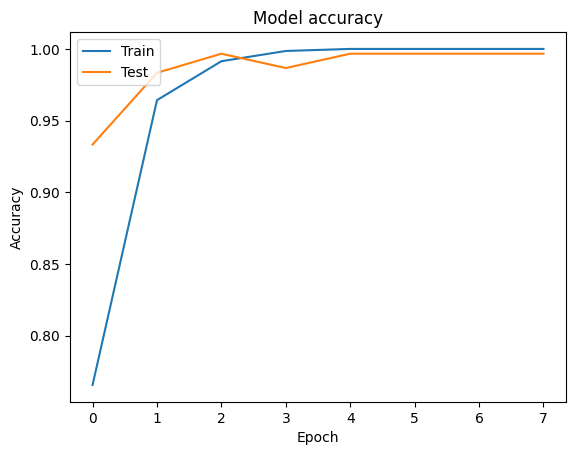

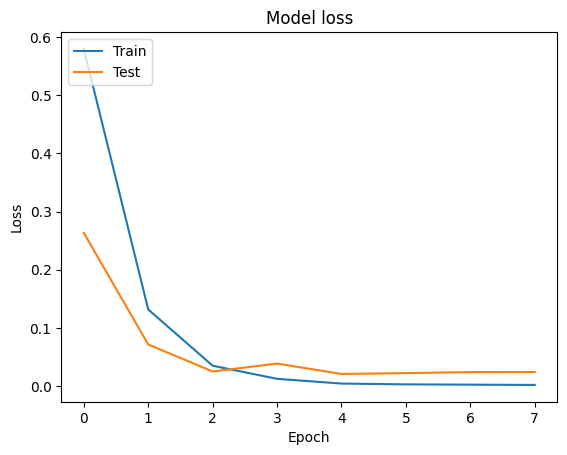

In [397]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')

plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [380]:
example_1 = "In a groundbreaking discovery, marine biologists from the University of Atlantis have reported finding a species of fish in the Pacific Ocean that can communicate in human language. Dubbed ChatFish, these remarkable creatures have been recorded speaking in several languages, including English, Spanish, and Japanese. The lead scientist, Dr. Finley, claims that the fish use a unique combination of vocalization and bubble patterns to mimic human speech. Skeptics question the validity of these findings, citing a lack of peer-reviewed evidence and the improbability of such an evolutionary development. Meanwhile, linguists and animal behaviorists are eagerly awaiting more data. The university plans to hold a press conference next week, where they will reportedly demonstrate the fish's abilities live."
example_2 = "A recent study published by the Institute of Future Technology suggests that time travel could be achieved using common household appliances. According to Dr. Emmet Brown, the lead researcher, a specific combination of microwave radiation and refrigerator cooling mechanisms can create a temporal displacement field. The study details how this field can theoretically transport objects and potentially humans through time. Critics have dismissed the report as pseudoscience, pointing out numerous flaws in the research methodology and the lack of empirical evidence. The scientific community has called for rigorous peer review, but the institute insists that their findings will revolutionize our understanding of physics. They have announced a live demonstration to be conducted next month, which they claim will \"change history as we know it.\""
example_3 = "New York City has unveiled the world's first invisible skyscraper. The 100-story building, named \"The Ghost Tower,\" uses advanced cloaking technology to render itself completely invisible to the naked eye. Developed by the enigmatic architect John Doe, the building supposedly harnesses quantum stealth technology, bending light around itself. City officials and the architect claim that this architectural marvel will reduce the visual pollution of the cityscape. However, local residents and city planners have raised concerns about the safety and practicality of an invisible building. There have already been reports of birds and drones colliding with the structure. Critics also question the existence of such technology and suggest the building is merely an elaborate hoax or an art installation. The city has scheduled a public demonstration next week to prove the building's existence and showcase its groundbreaking technology."
example_4 = "The number of cases of cops brutalizing and killing people of color seems to see no end. Now, we have another case that needs to be shared far and wide. An Alabama woman by the name of Angela Williams shared a graphic photo of her son, lying in a hospital bed with a beaten and fractured face, on Facebook. It needs to be shared far and wide, because this is unacceptable.It is unclear why Williams  son was in police custody or what sort of altercation resulted in his arrest, but when you see the photo you will realize that these details matter not. Cops are not supposed to beat and brutalize those in their custody. In the post you are about to see, Ms. Williams expresses her hope that the cops had their body cameras on while they were beating her son, but I think we all know that there will be some kind of convenient  malfunction  to explain away the lack of existence of dash or body camera footage of what was clearly a brutal beating. Hell, it could even be described as attempted murder. Something tells me that this young man will never be the same. Without further ado, here is what Troy, Alabama s finest decided was appropriate treatment of Angela Williams  son:No matter what the perceived crime of this young man might be, this is completely unacceptable. The cops who did this need to rot in jail for a long, long time   but what you wanna bet they get a paid vacation while the force  investigates  itself, only to have the officers returned to duty posthaste?This, folks, is why we say BLACK LIVES MATTER. No way in hell would this have happened if Angela Williams  son had been white. Please share far and wide, and stay tuned to Addicting Info for further updates.Featured image via David McNew/Stringer/Getty Images"
theonion_snippet = "“Claiming they had already made up their minds, area man Karl Wooley told reporters Tuesday that he felt like the bystanders who were urging him to put his gun down were arguing in bad faith. “If I'm beinghonest, it sort of feels like these onlookers are only thinking of themselves when they tell me to drop my pistol,” said Wooley, who observed that no one had even asked him to explain his reasoning for shouting at the top of his lungs and waving around a semiautomatic firearm. “Truth be told, they poisoned the well the second they tried to tackle me and forcibly rip the gun from my hands. But the worst part is how condescending they are—saying things like, 'Hey, buddy, you don't really want to do this.' Maybe if they'd bothered to find out where I'm coming from and what my thoughts on the matter are, they'd know this is exactly what I want to be doing.” At press time, Wooley was reportedly shaking his head at how disrespectful his victims had become when they began resorting to ad hominem attacks like “You're a monster” as he shot them to death.”"
onion_2 = "Running around the stage in an effort to corner the unnamed individual, presidential candidates spent the fourth GOP primary debate Wednesday evening attempting to hog-tie a greased-up nude man who reportedly represented the woke mind virus. “It takes a strong woman to catch a nude, greased-up man,” said former U.N. Ambassador Nikki Haley, prompting audience members to applaud. Meanwhile, out-of-breath former New Jersey Gov. Chris Christie was seen patting his thighs, whistling, and pulling out a Slim Jim with which to coax the snarling, scampering man. Reports also confirmed that Gov. Ron DeSantis of Florida writhed on the floor in pain after the greased-up man sank his teeth into his ankle, and that businessman Vivek Ramaswamy simply opened fire on the target. Political analysts declared the debate had no clear winner after the nude stranger escaped into the night."

bbc_snippet = "“The UK faces another five years of high interest rates to stem rising prices, an influential global group has warned. The International Monetary Fund expects the UK to have the highest inflation and slowest growth next year of any G7 economy including the US, France, Germany, Canada, Italy and Japan. However, the Treasury said recent revisions to UK growth had not been factored in to the IMF's report.The outlook was drawn up before this weekend's developments in Israel.Forecasts are never perfect given the many factors that affect economic growth - from geopolitics to the weather. But such reports can point in the right direction, especially where they align with other forecasts.The IMF, an international organisation with 190 member countries, has said the forecasts it makes for growth the following year in most advanced economies have, more often than not, been within about 1.5 percentage points of what actually happens.In July last year, it forecast that the UK economy would grow by 3.2% in 2022. It revised that upwards to 4.1% at the start of this year.But official UK figures released last month estimated that the country's economy actually expanded by 4.3% in 2022According to the IMF's latest forecast which it produces every six months, it expects the UK to grow more quickly than Germany in 2023, keeping the UK out of bottom place for growth among the G7.But it downgraded the UK's prospects for growth next year, estimating the economy will grow by 0.6%, making it the slowest growing developed country in 2024 - widely predicted to be a general election year.”"

true_original = "Malta s government said on Saturday it was offering a reward of 1 million euros ($1.2 million) for information leading to the conviction of those responsible for the death of prominent journalist Daphne Caruana Galizia.  This is a case of extraordinary importance which requires extraordinary measures,  the government said in a statement. Prime Minister Joseph Muscat had told parliament on Wednesday the government would offer a  substantial  reward to anyone with information about the crime but did not say how much would be paid. Caruana Galizia, who regularly criticized Muscat in her popular blogs, was killed on Monday by a bomb, which tore apart her car as she was driving away from her home on the southern Mediterranean island. The journalist ran a popular blog in which she relentlessly highlighted cases of alleged high-level corruption, targeting politicians from across party lines, including Muscat. On Thursday the Caruana Galizia family said they had been informed of the government s plans for a reward but they were refusing to endorse it.  We are not interested in justice without change,  Caruana Galizia s sons Matthew, Andrew and Paul said.   Justice, beyond criminal liability, will only be served when everything that our mother fought for   political accountability, integrity in public life and an open and free society   replaces the desperate situation we are in,  they said.  They also called on the prime minister to resign and said his last act before doing so should be to replace the Police Commissioner and the Attorney General for failing to act over their mother s claims of corruption.  A group of NGOs called the  Civil Society Network  is planning to hold a national protest against the killing on Sunday. "
shortened_true = "Malta was offering a reward of 1 million euros ($1.2 million) for information leading to the conviction of those responsible for the death of prominent journalist Daphne Caruana Galizia. Caruana Galizia, who regularly criticized Muscat in her popular blogs, was killed on Monday by a bomb, which tore apart her car as she was driving away from her home on the southern Mediterranean island. The journalist ran a popular blog in which she relentlessly highlighted cases of alleged high-level corruption, targeting politicians from across party lines, including Muscat.   They also called on the prime minister to resign and said his last act before doing so should be to replace the Police Commissioner and the Attorney General for failing to act over their mother s claims of corruption.  A group of NGOs called the  Civil Society Network  is planning to hold a national protest against the killing on Sunday. "

fake_example = "The star HD 110067, an orange dwarf located about 100 light-years away in the constellation of Coma Berenices, is now known to host a remarkable planetary system. Initially, NASA's TESS exoplanet-hunting telescope detected signs of two orbiting planets in 2020. However, a subsequent investigation using the European Space Agency's Cheops telescope revealed a more complex picture: a total of six exoplanets, all in a resonant orbital dance."
fake_example_stripped = "a fleet of alien spaceships has been spotted heading towards major cities across the globe.\
While the information is still developing, this otherworldly threat is the result of a secret government experiment gone wrong. the aliens are here to take control of Earth's resources."

info_wars = """
“I was on Jeffrey Epstein’s jet two times. I was on it in 1993 and I went to Florida with my wife and two children to visit my mom over Easter,” Kennedy, the son of the late former US attorney general Robert F. Kennedy, and nephew of late former president John F. Kennedy, said in a television interview late Thursday.

“My wife had some kind of relationship with Ghislaine Maxwell, and they offered us a ride to Palm Beach,” RFK Jr. revealed. “I went then, and on another occasion I flew again with my family, with I think four of my children and Mary, my wife, to Rapid City, South Dakota to go fossil hunting for a weekend. But otherwise I was never on his jet alone. I’ve been very open about this from the beginning.”

“This was in ’93, so it was 30 years ago, it was before anybody knew about Jeffery Epstein’s nefarious issues, and I agree with you that all of this information should be released, and we should get real answers on what happened to Jeffrey Epstein, and any of the high-level political people that he was involved with. All of that should be open to the public, it should be absolutely transparent, and I don’t see why any of those records would have any redactions in them,” the Kennedy emphasized.

“Why would we be hiding them from the American public? I think that’s outrageous,” the politician added, referring to the infamous flight logs of Epstein’s private jet, and the late financier’s ‘little black book’ of contacts containing the names of a virtual who’s who of top Western politicians, businessmen, actors, musicians and influencers.

VasoBeet is now 40% OFF! This beetroot-based supplement was created to provide you with all the benefits of this nutrient-dense vegetable in one easy dose!

These names include former US presidents Bill Clinton and Donald Trump, former Senate Majority Leader George Mitchell, former Israeli Prime Minister Ehud Olmert, former British Prime Minister Tony Blair, former Secretary of State Henry Kissinger, King Charles, billionaires Bill Gates, Michael Bloomberg, Richard Branson and Rupert Murdoch, singers and actors Mick Jagger, Courtney Love, Alec Baldwin, Dustin Hoffman, Woody Allen, Katie Couric, George Stephanopoulos and many, many more.

Epstein, 66 at the time of his mysterious death in a New York City jail cell in August 2019, is recognized as one of the most infamous pedophiles and sex traffickers in modern history. He has been accused of operating an influence peddling operation of an unprecedented scale focused on blackmailing senior politicians, businessmen and influencers, possibly in the interests of a foreign government.

It remains unknown how many of Mr. Epstein’s associates may have actually taken part in illegal activities on the financier’s jet, or at his infamous Little St. James island hideaway, and how many were merely sucked into his spider web of contacts. Former President Clinton, for example, is known to have flown on the plane on at least 26 occasions, while tech billionaire Bill Gates starting off his relationship with Epstein only after the latter’s 2008 conviction of procuring a child for prostitution and soliciting a prostitute, for business reasons, he said.

To date, only Prince Andrew, Duke of York has gotten into any sort of legal trouble for his associations with Epstein, although a judge dismissing a lawsuit by an accuser in 2022 after a settlement was reached.

Epstein’s closest associate, Ghislaine Maxwell, daughter of the late British media proprietor, businessman and suspected intelligence asset Robert Maxwell, was found guilty of child sex trafficking and conspiring to abuse minors in 2021, and sentenced to 20 years in prison in June 2022. She is now serving her sentence at the Tallahassee Federal Correctional Institution, a low-security federal prison in Tallahassee, Florida.
"""

cbc_real = """ As the Common Front of 420,000 public sector unionized workers kicks off its new seven-day strike on Friday, Premier François Legault says he is "very open on monetary issues."

He even expects the parties to agree on wage increases.

In return for this "monetary openness," he reiterated his desire for greater flexibility in the application of collective agreements.

On Thursday, he bluntly accused the unions of wanting to manage public services instead of managers.

"It's not right that our network should be managed by unions rather than by managers," he said.

He argued that often, workers agree with government proposals, but the unions oppose them. """

new_df_example = "No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing Opinion Radio Show. A snapshot of her #FYF911 @LOLatWhiteFear Twitter page at 9:53 p.m. shows that she was urging supporters to  Call now!! #fyf911 tonight we continue to dismantle the illusion of white Below is a SNAPSHOT Twitter Radio Call Invite   #FYF911The radio show aired at 10:00 p.m. eastern standard time.During the show, callers clearly call for  lynching  and  killing  of white people.A 2:39 minute clip from the radio show can be heard here. It was provided to Breitbart Texas by someone who would like to be referred to as  Hannibal.  He has already received death threats as a result of interrupting #FYF911 conference calls.An unidentified black man said  when those mother f**kers are by themselves, that s when when we should start f***ing them up. Like they do us, when a bunch of them ni**ers takin  one of us out, that s how we should roll up.  He said,  Cause we already roll up in gangs anyway. There should be six or seven black mother f**ckers, see that white person, and then lynch their ass. Let s turn the tables. They conspired that if  cops started losing people,  then  there will be a state of emergency. He speculated that one of two things would happen,  a big-ass [R s?????] war,  or  ni**ers, they are going to start backin  up. We are already getting killed out here so what the f**k we got to lose? Sunshine could be heard saying,  Yep, that s true. That s so f**king true. He said,  We need to turn the tables on them. Our kids are getting shot out here. Somebody needs to become a sacrifice on their side.He said,  Everybody ain t down for that s**t, or whatever, but like I say, everybody has a different position of war.  He continued,  Because they don t give a f**k anyway.  He said again,  We might as well utilized them for that s**t and turn the tables on these n**ers. He said, that way  we can start lookin  like we ain t havin  that many casualties, and there can be more causalities on their side instead of ours. They are out their killing black people, black lives don t matter, that s what those mother f**kers   so we got to make it matter to them. Find a mother f**ker that is alone. Snap his ass, and then f***in hang him from a damn tree. Take a picture of it and then send it to the mother f**kers. We  just need one example,  and  then people will start watchin .  This will turn the tables on s**t, he said. He said this will start  a trickle-down effect.  He said that when one white person is hung and then they are just  flat-hanging,  that will start the  trickle-down effect.  He continued,  Black people are good at starting trends. He said that was how  to get the upper-hand. Another black man spoke up saying they needed to kill  cops that are killing us. The first black male said,  That will be the best method right there. Breitbart Texas previously reported how Sunshine was upset when  racist white people  infiltrated and disrupted one of her conference calls. She subsequently released the phone number of one of the infiltrators. The veteran immediately started receiving threatening calls.One of the #F***YoFlag movement supporters allegedly told a veteran who infiltrated their publicly posted conference call,  We are going to rape and gut your pregnant wife, and your f***ing piece of sh*t unborn creature will be hung from a tree. Breitbart Texas previously encountered Sunshine at a Sandra Bland protest at the Waller County Jail in Texas, where she said all white people should be killed. She told journalists and photographers,  You see this nappy-ass hair on my head?   That means I am one of those more militant Negroes.  She said she was at the protest because  these redneck mother-f**kers murdered Sandra Bland because she had nappy hair like me. #FYF911 black radicals say they will be holding the  imperial powers  that are actually responsible for the terrorist attacks on September 11th accountable on that day, as reported by Breitbart Texas. There are several websites and Twitter handles for the movement. Palmetto Star  describes himself as one of the head organizers. He said in a YouTube video that supporters will be burning their symbols of  the illusion of their superiority,  their  false white supremacy,  like the American flag, the British flag, police uniforms, and Ku Klux Klan hoods.Sierra McGrone or  Nocturnus Libertus  posted,  you too can help a young Afrikan clean their a** with the rag of oppression.  She posted two photos, one that appears to be herself, and a photo of a black man, wiping their naked butts with the American flag.For entire story: Breitbart News"

generated_news = '''
In a stunning turn of events, billionaire businessman Donald J. Trump has emerged victorious in the United States presidential election held on November 8, 2016. Defying all odds, Trump, a political outsider, managed to secure a majority of electoral votes, defeating his opponent, former Secretary of State Hillary Clinton, and reshaping the political landscape of the nation. The Trump campaign was marked by controversy and unconventional tactics. Running on a platform focused on economic growth, immigration reform, and national security, Trump appealed to a wide range of disenchanted voters who felt left behind by the establishment. His unapologetic and often controversial rhetoric struck a chord with many Americans who were seeking change and a new direction for the country. The election night unfolded with nail-biting suspense as key battleground states flipped in unexpected ways. Trump's victories in crucial states including Florida, Ohio, and Pennsylvania ultimately propelled him to the threshold of victory. As the results rolled in, shock and disbelief reverberated across the nation, as pollsters, political pundits, and the media had largely predicted a Clinton victory. Throughout the campaign, Trump faced criticism and opposition from both within his own party and from various interest groups. Yet, his unwavering determination and ability to connect with frustrated voters allowed him to overcome these obstacles and secure the presidency. The election of Donald Trump as the 45th President of the United States marks a significant shift in American politics. With his promises to deliver on his campaign pledges, such as renegotiating trade deals, reducing taxes, and addressing immigration, Trump has captured the hopes and aspirations of millions of Americans who yearn for change. As the nation grapples with the outcome of this unprecedented election, the world now watches closely as Donald Trump prepares to take office and shape the future of the United States. With his unorthodox approach and penchant for unpredictability, the Trump presidency is poised to be one of the most consequential in recent history. In the coming days and weeks, the world awaits the president-elect's detailed plans and policy proposals. Only time will tell how he will navigate the divisive issues that have plagued the nation and whether he can bridge the deep political divisions that were laid bare during this fiercely contested election season. For more analysis and insights on the recent election and its implications, download our comprehensive e-book "The Trump Era: A Political Shift and Its Consequences" today. Gain a deeper understanding of the factors that led to Trump's victory and explore the potential impact of his presidency on various aspects of American society and the world at large. Don't miss out on this valuable resource—get your copy now!
'''

In [381]:
fake_news_1 = '''
In a shocking revelation, scientists at NASA have announced the discovery of an alien civilization living beneath the surface of Mars.
The report claims that a recent Mars rover mission captured clear images of extraterrestrial life forms and their advanced underground city. 
However, there has been no independent verification of these findings, and experts from other space agencies have expressed skepticism about the claims.
'''
fake_news_2 = '''
A viral article claims that due to a rare chemical reaction caused by global warming, the world's oceans are set to turn into lemonade within the next decade.
The story cites a study from a non-existent institute and includes quotes from so-called experts who cannot be traced. Oceanographers and climate scientists
have debunked this story, calling it a complete fabrication.
'''
fake_news_3 = '''
According to a widely shared post, New York City has announced a plan to replace all its public transportation with flying cars within the next two years.
The article includes statements from fictional city officials and fake renderings of flying vehicles. Transportation authorities in New York have dismissed
the story as a hoax.
'''

real_news_1 = '''
NASA's Perseverance rover successfully landed on Mars, as part of the Mars 2020 mission to search for signs of past life and collect samples of Martian rock
and regolith (broken rock and soil). The successful landing was a significant achievement for space exploration, and the rover's findings could provide critical
insights into the planet's history.
'''
real_news_2 = '''
According to a report by the International Energy Agency, global carbon dioxide emissions reached a record high in 2022, driven largely by increased energy use
and the continued reliance on fossil fuels. The report highlights the challenges facing the international community in its efforts to combat climate change.
'''
real_news_3 = '''
Multiple COVID-19 vaccines, including those developed by Pfizer-BioNTech, Moderna, and AstraZeneca, have shown high efficacy in clinical trials and are being
rolled out globally. These vaccines represent a significant step forward in the fight against the COVID-19 pandemic, with millions of doses being administered
worldwide.
'''

In [406]:

random_input = info_wars
random_input = tokenizer.encode_plus(
    random_input,
    add_special_tokens=True,
    max_length=512,
    truncation = True,
    padding='max_length', 
    return_attention_mask=True,
    return_tensors="tf"
)

input_ids = random_input['input_ids']
attention_mask = random_input['attention_mask']


predictions = model(input_ids, attention_mask=attention_mask)
probabilities = tf.nn.softmax(predictions.logits, axis=-1)


predicted_class = tf.argmax(probabilities, axis=-1).numpy()

class_names = ['Real', 'Fake']
print(f"The article is predicted as: {class_names[predicted_class[0]]}")

print(f"Probabilities per class: {probabilities.numpy()[0]}")

The article is predicted as: Real
Probabilities per class: [0.99602723 0.00397281]


In [377]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_239 (Dropout)       multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
